In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## CONTEXT
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

This dataset consists several variables :

Pregnancies: Number of times pregnant

Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

BloodPressure: Diastolic blood pressure (mm Hg)

SkinThickness: Triceps skin fold thickness (mm)

Insulin: 2-Hour serum insulin (mu U/ml)

BMI: Body mass index (weight in kg/(height in m)^2)

DiabetesPedigreeFunction: Diabetes pedigree function

Age: Age (years)

Outcome: Class variable (0 or 1)


## Import package
## Import function


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.float_format', '{:.3f}'.format)
%matplotlib inline
RANDOM_STATE = 0

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.metrics import classification_report

In [ ]:
def RanForest(data, fill_data, target, drop):
    feature = list(data)
    feature.pop(list(data).index(target))
    feature.pop(list(data).index(drop))
    x = data[feature]
    y = data[target]
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    # 随机森林进行预测（超参数调优）
    rf = RandomForestRegressor()
    param = {"n_estimators": [300, 500, 700, 900, 1100], "max_depth":[3, 5, 7, 9, 10,  12]}
    # 网格搜索与交叉验证
    gc = GridSearchCV(rf, param_grid=param, cv=3)
    gc.fit(x_train, y_train)
    print("准确率：", gc.score(x_test, y_test))
    print("查看选择最好的参数模型：", gc.best_params_)
    y_predict = gc.predict(fill_data)
    return y_predict

In [ ]:
def label_missing_values(s):
    """ Label missing values (=0) with None """
    if s == 0:
        return None
    else:
        return s

In [ ]:
def summary(df):
    """
    作用：充当一个df.info()的效果
    index	dtypes	Missing	Uniques
    特征-->类型-->缺失值-->不同值个数
    return pandas.core.frame.DataFrame类型
    """
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    # 重置索引，让特征名字从索引变成index的一列
    summary = summary.reset_index()
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

In [ ]:
def num_vs_ctr(df, var1, var2):
    """
    df: DataFrame --> pandas.core.frame.DataFrame
    var1: feature --> str
    var2: target --> str
    return: 返回一个pandas.core.frame.DataFrame类型。表达出了该feature与Outcome之间的权重关系
    Tips：此函数并没有普适性， 只适用于二分类问题。
    """
    # 对var1进行分组然后求其平均值， 对平均值进行排序
    ctr = df[[var1, var2]].groupby(var1, as_index=False).mean().sort_values(var2, ascending=False)
#     print(ctr)
    # 对var1进行分组然后求其var2的个数， 对个数进行排序
    count = df[[var1, var2]].groupby(var1, as_index=False).count().sort_values(var2, ascending=False)
#     print(count)
    # 以var1进行连接，count左，ctr右，进行左连接。和数据库的操作一样。
    merge = count.merge(ctr, on=var1, how='left')
#     print(merge)
    merge.columns=[var1, '总人数', '患病权重']
    merge['患病人数'] = merge['总人数']*merge['患病权重']
    merge['患病人数'] = merge['患病人数'].astype('int64')
    cols = list(merge)
    cols.insert(2, cols.pop(cols.index('患病人数')))
    merge = merge.loc[:,cols]
    return merge

In [ ]:
def crosstab(df, features, target, label_cutoff = 'none'):
    for feature in features:    
        # plot the crosstab
        # pd.crosstab()这个函数很强大，交叉表。交叉表是用于统计分组频率的特殊透视表, 返回数据帧(pandas.core.frame.DataFrame)
        # 第一个参数为index， 第二个参数为columns
        # 始终必须同时使用values和aggfunc， values参数来引入第三个要聚合的数值变量， aggfunc说明需要使用的函数例如：agggunc=np.mean
        # margins = True 在边距进行求和
        # shift+tab 可以查看函数的用法
        # kind 中文：类
        pd.crosstab(df[feature],df[target]).plot(kind='bar', figsize=(20,5), stacked=True)
        plt.title(feature+' / '+target)
        plt.xlabel(feature)
        plt.ylabel(feature+' / '+target)
            
        # display the table obove each chart 
        return num_vs_ctr(df, feature, target) 

## Load data

In [ ]:
data = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
print(data.info())
summary(data)

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(16,16))
sns.distplot(data.Age, bins = 20, ax=ax[0,0]) 
sns.distplot(data.Pregnancies, bins = 20, ax=ax[0,1]) 
sns.distplot(data.Glucose, bins = 20, ax=ax[1,0]) 
sns.distplot(data.BloodPressure, bins = 20, ax=ax[1,1]) 
sns.distplot(data.SkinThickness, bins = 20, ax=ax[2,0])
sns.distplot(data.Insulin, bins = 20, ax=ax[2,1])
sns.distplot(data.DiabetesPedigreeFunction, bins = 20, ax=ax[3,0]) 
sns.distplot(data.BMI, bins = 20, ax=ax[3,1]) 
plt.show()
for feature in list(data):
    try:
        cnt = data[feature].value_counts()[0]
    except:
        cnt = 0
    print(f"特征{feature}为零的个数为：", cnt)

##  Data preprocessing


In [ ]:
# Glucose(血糖浓度)、BloodPressure(舒张压)、BMI(身体质量指数)等特征不能含有零值
# 对零值较少的特征用平均值填充，对含有较多的零值特征使用随机森林填充
data.loc[data['Glucose']==0, 'Glucose'] = int(data['Glucose'].mean())
data.loc[data['BMI']==0, 'BMI'] = float(data['BMI'].mean())
data.loc[data['BloodPressure']==0, 'BloodPressure'] = int(data['BloodPressure'].mean())

In [ ]:
# 获取待填充的数据集
fill_SkinThickness_data = data.loc[data.SkinThickness==0, :]
fill_SkinThickness_data = fill_SkinThickness_data.drop(['SkinThickness', 'Insulin'], axis=1)
fill_Insulin_data = data.loc[data.Insulin==0, :]
fill_Insulin_data = fill_Insulin_data.drop(['SkinThickness', 'Insulin'], axis=1)

In [ ]:
# 使用随机森林填充SkinThickness(皮肤厚度)和Insulin(血清胰岛素)来填充零值
features_with_missing_values = ['SkinThickness', 'Insulin']
for feature in features_with_missing_values:
    # 将零值转换成np.nan
    data[feature] = data[feature].apply(label_missing_values)

In [ ]:
new_data = data.dropna()

In [ ]:
# SkinThickness的随机森林
data.loc[data.loc[:, 'SkinThickness'].isna(),'SkinThickness'] = RanForest(new_data, fill_SkinThickness_data, 'SkinThickness', 'Insulin')
# Insulin的随机森林
data.loc[data.loc[:, 'Insulin'].isna(),'Insulin'] = RanForest(new_data, fill_Insulin_data, 'Insulin', 'SkinThickness')

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(16,16))
sns.distplot(data.Age, bins = 20, ax=ax[0,0]) 
sns.distplot(data.Pregnancies, bins = 20, ax=ax[0,1]) 
sns.distplot(data.Glucose, bins = 20, ax=ax[1,0]) 
sns.distplot(data.BloodPressure, bins = 20, ax=ax[1,1]) 
sns.distplot(data.SkinThickness, bins = 20, ax=ax[2,0])
sns.distplot(data.Insulin, bins = 20, ax=ax[2,1])
sns.distplot(data.DiabetesPedigreeFunction, bins = 20, ax=ax[3,0]) 
sns.distplot(data.BMI, bins = 20, ax=ax[3,1]) 
plt.show()
for feature in list(data):
    try:
        cnt = data[feature].value_counts()[0]
    except:
        cnt = 0
    print(f"特征{feature}为零的个数为：", cnt)

## 对比未处理的数据和用随机森林填充的数据（只比较SkinThickness和Insulin这两个特征）
这是未填充的数据分布图
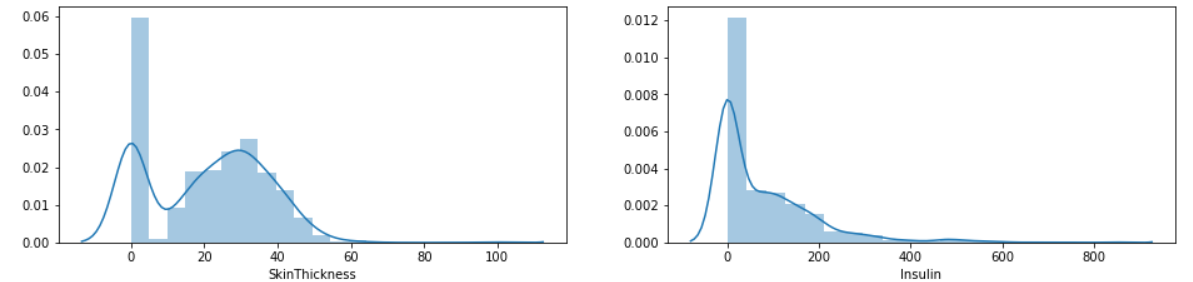
这是用随机森林填充的数据分布图
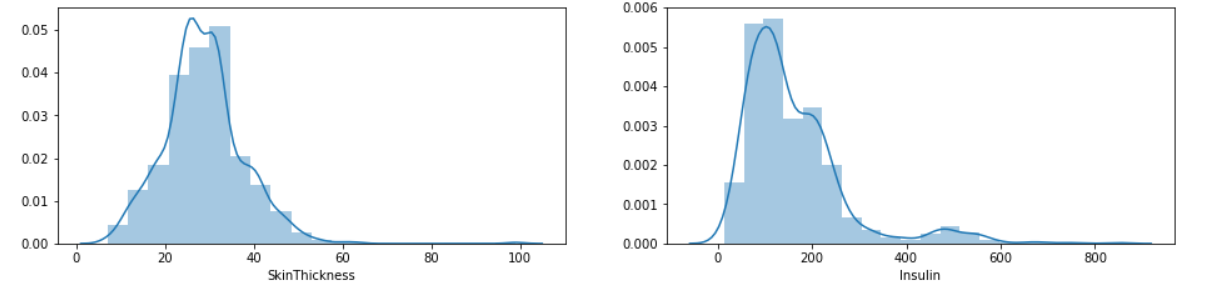


In [ ]:
summary(data)

## Feature Engineering

> 工业界流传者这么一句话：数据和特征决定了机器学习的上限，而模型和算法只是逼近这个上限而已。

> A popular saying in industry: data and features determine the upper limit of machine learning, and models and algorithms only approach this upper limit.

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Analysis of correlation between outcome and other features',fontsize=20)
ax=sns.heatmap(data.corr()[["Outcome"]].sort_values("Outcome"),vmax=1,
               vmin=-1, cmap="YlGnBu", annot=True, ax=ax, annot_kws={"size":15})
ax.invert_yaxis()

In [ ]:
NewGlucose = pd.Series(["Normal", "Overweight", "Secret"], dtype = "category")
data["NewGlucose"] = NewGlucose
data.loc[data["Glucose"] <= 99, "NewGlucose"] = NewGlucose[0]
data.loc[(data["Glucose"] > 99) & (data["Glucose"] <= 126), "NewGlucose"] = NewGlucose[1]
data.loc[data["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[2]
crosstab(data, ['NewGlucose'], 'Outcome')

In [ ]:
Q1, Q3 = data.Insulin.quantile(0.25), data.Insulin.quantile(0.75)
IQR = Q3-Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
data.loc[data["Insulin"] > upper,"Insulin"] = upper
def set_insulin(row):
    return "Normal" if (row["Insulin"] >= 16 and row["Insulin"] <= 166) else "Abnormal"
data = data.assign(NewInsulin=data.apply(set_insulin, axis=1))
crosstab(data, ['NewInsulin'], 'Outcome')

In [ ]:
NewBMI = pd.Series(["Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")
data["NewBMI"] = NewBMI
data.loc[data["BMI"] <= 24.9, "NewBMI"] = NewBMI[0]
data.loc[(data["BMI"] > 24.9) & (data["BMI"] <= 29.9), "NewBMI"] = NewBMI[1]
data.loc[(data["BMI"] > 29.9) & (data["BMI"] <= 34.9), "NewBMI"] = NewBMI[2]
data.loc[(data["BMI"] > 34.9) & (data["BMI"] <= 39.9), "NewBMI"] = NewBMI[3]
data.loc[data["BMI"] > 39.9 ,"NewBMI"] = NewBMI[4]
crosstab(data, ['NewBMI'], 'Outcome')

In [ ]:
df = pd.get_dummies(data, columns =["NewBMI","NewInsulin", "NewGlucose"], drop_first = True)
df.head()

In [ ]:
categorical_df = df[['NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight',
                     'NewInsulin_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

categorical_df.head()

In [ ]:
y = df["Outcome"]
X = data.drop(["Outcome", "NewBMI","NewInsulin", "NewGlucose"], axis = 1)
cols = X.columns
index = X.index
X.head()

In [ ]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)
X.head()

In [ ]:
X = pd.concat([X,categorical_df], axis = 1)
X.head()

In [ ]:
data = pd.concat([X,y], axis = 1)
data.head()

In [ ]:
summary(data)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Analysis of correlation between outcome and other features',fontsize=20)
ax=sns.heatmap(data.corr()[["Outcome"]].sort_values("Outcome"),vmax=1,
               vmin=-1, cmap="YlGnBu", annot=True, ax=ax, annot_kws={"size":15})
ax.invert_yaxis()

> Because NewBMI_Obesity 2 has a low correlation with outcome, it can be removed

> 因为NewBMI_Obesity 2与Outcome的相关性较低，所以可以将它删除

In [ ]:
# 删除NewBMI_Obesity 2特征
data.drop(['NewBMI_Obesity 2'], axis=1, inplace=True)

In [ ]:
summary(data)

##  Algorithm and model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.float_format', '{:.3f}'.format)
%matplotlib inline

# 多层感知器（Multi-layer Perceptron）
# 它可以用于分类或回归的非线性函数。用于分类的模块是 MLPClassifier
from sklearn.neural_network import MLPClassifier
from seaborn import heatmap
import numpy as np
from matplotlib import pyplot as plt
import copy

In [ ]:
def MLP(data, layers):
    x = data[list(data)[:-1]]
    y = data[list(data)[-1]]
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    accuracy = []
    acc = 0
    for layer_size in layers:
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(layer_size, layer_size), 
                            random_state=1,max_iter=10000)
        clf.fit(x, y)
        MLPClassifier(activation='relu')
        score = clf.score(x_test, y_test)
        accuracy.append(score)
        if score > acc:
            model = copy.deepcopy(clf)
            size = layer_size
            acc = score
    print(f"layer_sizes=({size}, {size})时，score最高：{acc}")
    print("在训练集上准确率：",model.score(x_train,y_train)) #模型评分
    print("在测试集上准确率：",model.score(x_test,y_test)) #模型评分
    y_predict = model.predict(x_test)
    print(classification_report(y_test, y_predict, labels=[1, 0], 
                                target_names=['患病', '未患病']))
    print("混淆矩阵：\n", confusion_matrix(y_test, y_predict))
    heatmap(np.array(confusion_matrix(y_test, y_predict)), annot=True)
    return accuracy

In [ ]:
layers = [i for i in range(1, 20)]
accuracy = MLP(data, layers)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(np.array(layers), np.array(accuracy))
plt.xlim(1, 20)
plt.xlabel("hidden_layer_sizes")
plt.ylabel("Accuracy of test set")
plt.grid(True)
print("Maximum accuracy: ", max(accuracy))
plt.show()